### Workspace Prep

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger

import tensorboard

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import tqdm as notebook_tqdm



# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\utils')
sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\lstm')
sys.path.insert(1, r'H:\My Drive\SP23\ML\envs\groupWork\utils')
sys.path.insert(1, r'H:\My Drive\SP23\ML\envs\groupWork\lstm')

import preprocessing as pp
from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

from lstm_model import (BasicLSTM, matrixLSTM)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Uncomment below to install missing modules

In [65]:
# !pip install ipywidgets

In [66]:
# pip install tensorboard

In [67]:
# pip install --ignore-installed PyYAML  # might be necessary to run before installing pytorch

In [68]:
# pip install pytorch-lightning

In [69]:
# pip install torch

### Load and Pre-processs Stock Data

In [70]:
df_sb = pd.read_csv('SBUX.csv', index_col='Date', parse_dates=True)

In [71]:
display(df_sb)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,81.116577,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,82.634186,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,83.065117,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,83.168152,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,82.559242,7296900
...,...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,97.790939,6952700
2020-12-07,102.010002,102.220001,100.690002,101.410004,96.959137,4514800
2020-12-08,100.370003,101.570000,100.010002,101.209999,96.767899,3911300


<Axes: title={'center': 'Starbucks Sales Volume'}, xlabel='Date'>

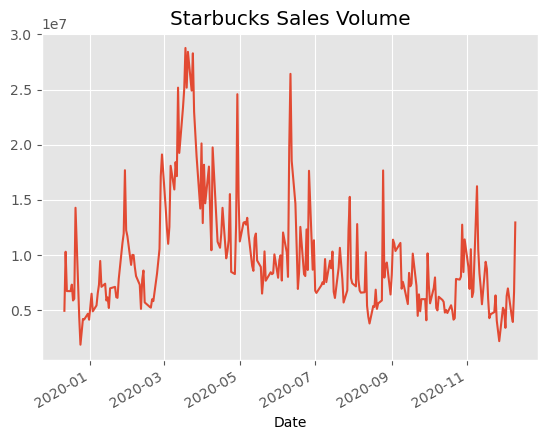

In [72]:
df_sb['Volume'].plot(title='Starbucks Sales Volume')

In [73]:
def processdata(df, day_feat, day_targ):
    df_scaled = pp.std_values(df, 'minmax')

    X_train, X_test, T_train, T_test = pp.split_data_validate(df_scaled, 'Volume')

    dl_train, ds_train = pp.lstm_timeseries_feat_and_targ(X_train, T_train, day_feat, day_targ, None )
    dl_test, ds_test = pp.lstm_timeseries_feat_and_targ(X_test, T_test, day_feat, day_targ, None)

    return dl_train, ds_train, dl_test, ds_test

def train_model(model, data, epochs, logger_name):
    logger = TensorBoardLogger("lightning_logs", name=logger_name)
    trainer = pl.Trainer(max_epochs=epochs,logger=logger)

    trainer.fit(model, train_dataloaders=data)
    trainer.test(model,dataloaders=dl_test)

dl_train, ds_train, dl_test, ds_test = processdata(df_sb, 3, 0)



## Test Our LSTM Model On Starbucks Data

In [74]:
%autoreload 2

our_model = BasicLSTM(num_feat=5, num_hiddens=1, num_out=1, lr=0.01)

train_model(our_model, dl_train, 10, 'our_model')

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.

  | Name | Type | Params
------------------------------
------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.012910056287017522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [94]:
%autoreload 2

our_model_matrix = matrixLSTM(num_feat=5, num_hiddens=1, num_out=1, lr=0.01)

train_model(our_model_matrix, dl_train, 10, 'matrix_model')

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.011720728376186283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Build Pytorch LSTM Model

In [75]:
class LSTMval(pl.LightningModule):
    def __init__(self, num_feat, num_hiddens, num_layers, lr):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = num_feat #input size
        self.hidden_size = num_hiddens #hidden state
        # self.seq_length = seq_length #sequence length
        self.lr = lr
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, batch_first=True) #lstm
    
    def forward(self,x):
        # h_0 = Variable(torch.zeros(self.num_layers, self.hidden_size)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, self.hidden_size)) #internal state
        # print(h_0,c_0)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        return output
    

    def configure_optimizers(self):
        return torch.optim.NAdam(self.parameters(), lr = self.lr)
    
    def training_step(self,batch,batch_idx):
        input_i, label_i = batch
        # print(input_i[0],torch.transpose(input_i[0],0,1))
        output_i = self.forward(torch.transpose(input_i[0],0,1))[0]
        
        loss = (output_i - label_i)**2
        
        self.log("training loss", loss, logger=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(torch.transpose(input_i[0],0,1))[0]
        test_loss = (output_i - label_i)**2
        
        self.log("test_loss", test_loss, on_step=True, logger=True)

    def makepred(self, dataset):
        y = []
        t = []

        h_hist=[]
        c_hist=[]
        x_hist=[]

        for ii in dataset:
            input_i, lab = ii

            y_i = self.forward(torch.transpose(input_i,0,1))[0]

            y_i = (y_i.detach().numpy())

            y.append(y_i)
            t.append(lab.numpy())

        return y, t


### Test Pytorch LSTM Model on Starbucks Data

In [76]:
val_mdl = LSTMval(num_feat = 5, num_hiddens = 1, num_layers = 1, lr = 0.01).double()
# logger = TensorBoardLogger("lightning_logs", name="SBUX")
# trainer = pl.Trainer(max_epochs=3,logger=logger)
# trainer.fit(val_mdl, train_dataloaders =dl_train)

train_model(val_mdl, dl_train, 10, 'val_model')


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 32    
------------------------------
32        Trainable params
0         Non-trainable params
32        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.011688869232728605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [96]:
y_train_val, t_train_val = val_mdl.makepred(ds_train)
y_test_val, t_test_val = val_mdl.makepred(ds_test)

y_train_our, t_train_our = our_model.makepred(ds_train)[0:2]
y_test_our, t_test_our = our_model.makepred(ds_test)[0:2]

y_train_mat, t_train_mat = our_model_matrix.makepred(ds_train)
y_test_mat, t_test_mat = our_model_matrix.makepred(ds_test)



ValueError: not enough values to unpack (expected 4, got 1)

In [78]:
def plot_results(t_train, t_test, y_train, y_test):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axs[0].scatter(y_train, t_train)
    axs[0].set_title('Training')

    axs[1].scatter(y_test, t_test)
    axs[1].set_title('Testing')

In [79]:
from sklearn.metrics import (r2_score, mean_absolute_percentage_error)


def test_r2(t_train, t_test, y_train, y_test):

    train_r2 = r2_score(t_train, y_train)
    test_r2 = r2_score(t_test, y_test)

    print('The r2 training score is ', train_r2)
    print('The r2 testing score is ', test_r2)

def test_mape(t_train, t_test, y_train, y_test):

    train_mape = mean_absolute_percentage_error(t_train, y_train)
    test_mape = mean_absolute_percentage_error(t_test, y_test)

    print('The mape training score is ', train_mape)
    print('The mape testing score is ', test_mape)

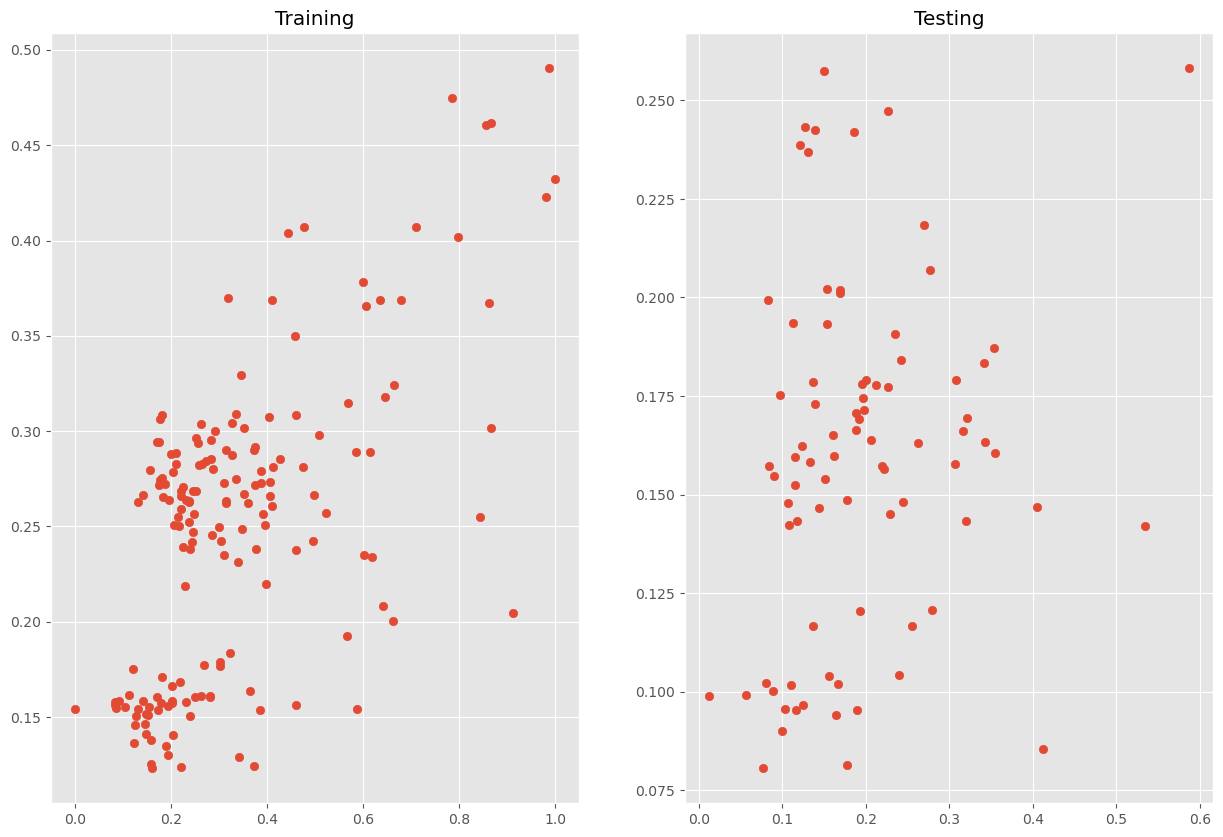

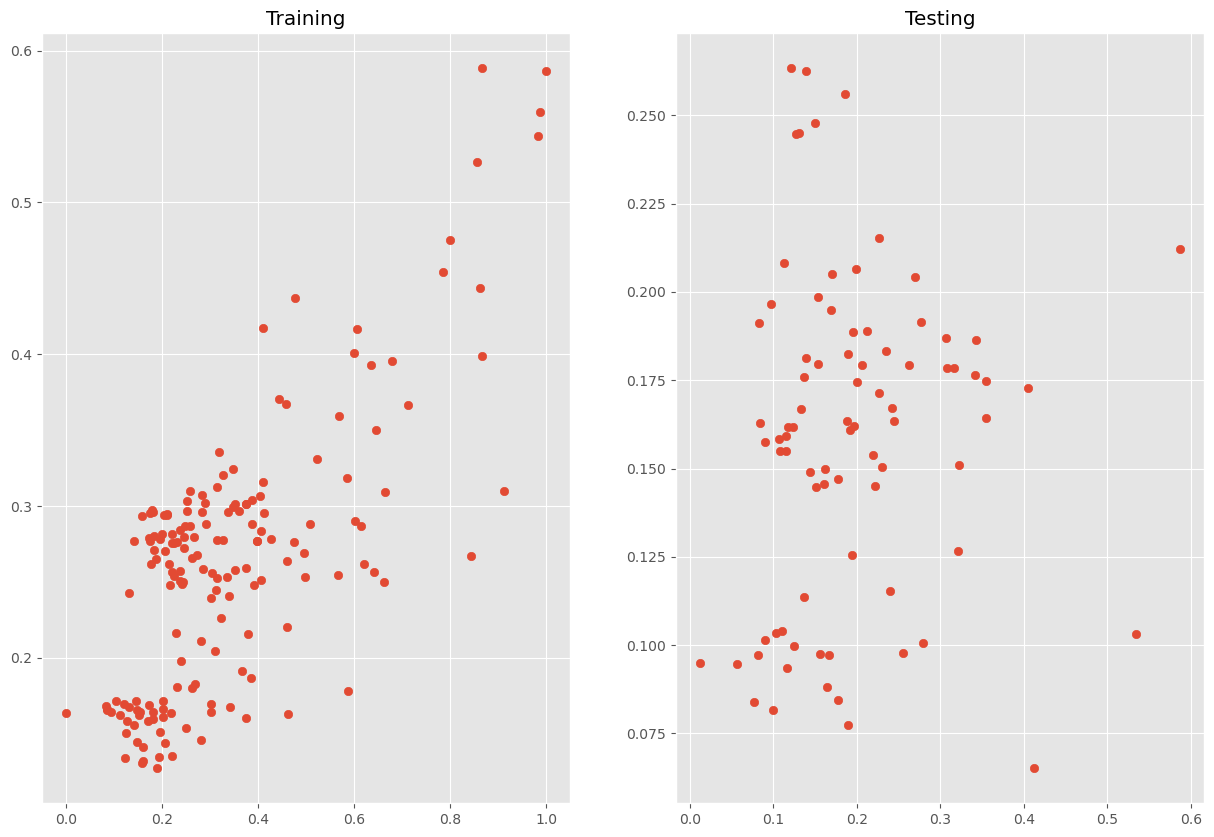

In [80]:
plot_results(y_train_val, y_test_val, t_train_val, t_test_val)
plot_results(y_train_our, y_test_our, t_train_our, t_test_our)
plot_results(y_train_mat, y_test_mat, t_train_mat, t_test_mat)


In [81]:
print('validation model')
test_r2(y_train_val, y_test_val, t_train_val, t_test_val)
print('our model')
test_r2(y_train_our, y_test_our, t_train_our, t_test_our)
print('our mat model')
test_r2(y_train_mat, y_test_mat, t_train_mat, t_test_mat)


validation model
The r2 training score is  -4.808379577489186
The r2 testing score is  -4.980536907204783
our model
The r2 training score is  -2.603215024765839
The r2 testing score is  -5.032590947651065


In [82]:
print('validation model')
test_mape(y_train_val, y_test_val, t_train_val, t_test_val)
print('our model')
test_mape(y_train_our, y_test_our, t_train_our, t_test_our)
print('our mat model')
test_mape(y_train_mat, y_test_mat, t_train_mat, t_test_mat)


validation model
The mape training score is  0.5210943269072605
The mape testing score is  0.5218124259161157
our model
The mape training score is  0.44526191566292633
The mape testing score is  0.5809913974449373


In [83]:
for name, param in val_mdl.named_parameters():
    if param.requires_grad:
        print(name,"\n", param.data)
        print(np.shape(param.data))
        print()

lstm.weight_ih_l0 
 tensor([[ 0.7427,  1.4840,  1.7044,  0.3397,  1.3113],
        [ 0.5585,  0.7566, -0.6956, -0.0219, -0.5341],
        [ 0.2461,  1.4161,  1.6269,  1.0386,  1.6031],
        [-0.8987, -0.8149, -0.9749, -0.8362,  0.5840]], dtype=torch.float64)
torch.Size([4, 5])

lstm.weight_hh_l0 
 tensor([[-0.1660],
        [ 0.7957],
        [ 0.9311],
        [-0.8540]], dtype=torch.float64)
torch.Size([4, 1])

lstm.bias_ih_l0 
 tensor([0.8354, 0.6220, 0.3307, 0.1812], dtype=torch.float64)
torch.Size([4])

lstm.bias_hh_l0 
 tensor([2.6475, 0.6070, 2.1870, 0.4841], dtype=torch.float64)
torch.Size([4])



In [84]:
for name, param in our_model.named_parameters():
    if param.requires_grad:
        print(name,"\n", param.data)
        print()

wf1 
 tensor([[-1.4377, -0.8599, -1.0849, -0.6609, -1.3722]])

wf2 
 tensor([[-1.2015]])

bf 
 tensor([-1.2781])

bf2 
 tensor([-1.2781])

wi1 
 tensor([[1.1013, 1.5732, 1.4515, 0.3947, 1.5679]])

wi2 
 tensor([[1.0279]])

bi 
 tensor([1.5896])

bi2 
 tensor([1.5896])

wo1 
 tensor([[-0.4916, -0.3868, -0.7103, -1.3753, -0.6348]])

wo2 
 tensor([[-1.8479]])

bo 
 tensor([0.6908])

bo2 
 tensor([0.6908])

wcc1 
 tensor([[ 0.3674,  1.7789,  0.8737, -0.3183,  0.7949]])

wcc2 
 tensor([[-3.5894]])

bcc 
 tensor([0.8185])

bcc2 
 tensor([0.8185])

